<h1>NYC Rent Affordability Investigation:<br>Change Point Detection & Forecasting</h1>

This is an investigation of rent affordability in NYC using neighborhood-level and borough-level from 2012-2022. 

I am using median rent data from the [Streeteasy Dashboard](https://streeteasy.com/blog/data-dashboard/), and median income data from the [U.S. Census American Community Survey](https://www.census.gov/programs-surveys/acs/data.html).

Here, I'll be using the Rupture package for identifying sudden shifts in borough-level rent & income data. Afterwards, I'll use Meta's Prophet package to forecast that borough-level rent & income data out to 12-24 months into the future.

# Importing packages and modules

In [27]:
# data management + manipulation
import pandas as pd
import numpy as np
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
# env vars + Big Query access
import os
import json
from google.cloud import bigquery
from google.oauth2 import service_account
# changepoint detection module
import ruptures as rpt
# removing excess logs
import warnings
warnings.filterwarnings('ignore')

# Import rent and income data from Big Query

In [3]:
# configure Big Query connection
PROJECT_ID = "rent-affordability"
DATASET_ID = "nyc_analysis"
service_account_info = json.loads(os.environ["GOOGLE_CREDENTIALS_JSON"])
credentials = service_account.Credentials.from_service_account_info(service_account_info)
client = bigquery.Client(project=PROJECT_ID, credentials=credentials)

In [4]:
# importing monthly median rent data
rent_query = """
SELECT 
    b.name as borough,
    mr.year,
    mr.month,
    AVG(mr.all_apartments) as avg_rent_all,
    AVG(mr.one_bedroom) as avg_rent_1bed,
    AVG(mr.three_plus_bedroom) as avg_rent_3bed
FROM nyc_analysis.fact_median_rent mr
JOIN nyc_analysis.ref_neighborhoods n ON mr.neighborhood_id = n.neighborhood_id
JOIN nyc_analysis.ref_boroughs b ON mr.borough_id = b.borough_id
WHERE mr.all_apartments IS NOT NULL
GROUP BY b.name, mr.year, mr.month
ORDER BY b.name, mr.year, mr.month
"""

rent_df = client.query(rent_query).to_dataframe()
rent_df['date'] = pd.to_datetime(rent_df[['year', 'month']].assign(day=1))
rent_df = rent_df.sort_values('date')
print(f"Loaded {len(rent_df)} monthly rent records")
rent_df

Loaded 756 monthly rent records


,borough,year,month,avg_rent_all,avg_rent_1bed,avg_rent_3bed,date
0,Bronx,2010,01,1361.333333333,500.000000000,833.333333333,2010-01-01
189,Brooklyn,2010,01,2006.370370370,1125.296296296,929.037037037,2010-01-01
567,Queens,2010,01,1571.916666667,741.166666667,591.666666667,2010-01-01
378,Manhattan,2010,01,3088.500000000,2454.571428571,4880.642857143,2010-01-01
568,Queens,2010,02,1539.153846154,603.846153846,419.230769231,2010-02-01
...,...,...,...,...,...,...,...
187,Bronx,2025,08,2659.769230769,1267.153846154,965.384615385,2025-08-01
377,Brooklyn,2025,09,3593.700000000,2898.300000000,4548.100000000,2025-09-01
188,Bronx,2025,09,2601.266666667,1152.666666667,881.666666667,2025-09-01
566,Manhattan,2025,09,4911.096774194,4420.645161290,8034.806451613,2025-09-01


In [5]:
# importing year-over-year percentage change rent data
yoy_rent_query = """
SELECT 
    borough_name as borough,
    year,
    AVG(yoy_change_pct_all) as yoy_rent_change_pct_all,
    AVG(yoy_change_pct_1bdr) as yoy_rent_change_pct_1bed,
    AVG(yoy_change_pct_3bdr) as yoy_rent_change_pct_3bed
FROM nyc_analysis.agg_yoy_rent_change
WHERE yoy_change_pct_all IS NOT NULL
GROUP BY borough_name, year
ORDER BY borough_name, year
"""

yoy_rent_df = client.query(yoy_rent_query).to_dataframe()
print(f"Loaded {len(yoy_rent_df)} YoY rent records")
yoy_rent_df

Loaded 60 YoY rent records


,borough,year,yoy_rent_change_pct_all,yoy_rent_change_pct_1bed,yoy_rent_change_pct_3bed
0,Bronx,2011,-11.445000000,20.960000000,41.400000000
1,Bronx,2012,12.114000000,120.400000000,7.650000000
2,Bronx,2013,3.497777778,-57.132500000,-59.000000000
3,Bronx,2014,5.374545455,240.780000000,20.390000000
4,Bronx,2015,6.770000000,-5.230769231,-10.070000000
5,Bronx,2016,9.224166667,4.312631579,-18.612000000
6,Bronx,2017,10.806400000,27.962777778,-26.135000000
7,Bronx,2018,6.642666667,-26.999473684,61.543333333
8,Bronx,2019,2.661785714,31.848125000,17.298461538
9,Bronx,2020,1.048928571,-31.472857143,-83.362941176


In [6]:
# importing income data
income_query = """
SELECT 
    b.name as borough,
    mi.year,
    AVG(mi.income_all_hhs) as avg_income_all_hhs,
    AVG(mi.income_singles) as avg_income_singles,
    AVG(mi.income_married_kids) as avg_income_married_kids,
    AVG(mi.income_other_kids) as avg_income_other_kids
FROM nyc_analysis.fact_median_income mi
JOIN nyc_analysis.ref_boroughs b ON mi.borough_id = b.borough_id
WHERE mi.income_all_hhs IS NOT NULL
GROUP BY b.name, mi.year
ORDER BY b.name, mi.year
"""

income_df = client.query(income_query).to_dataframe()
print(f"Loaded {len(income_df)} annual income records")
income_df


Loaded 50 annual income records


,borough,year,avg_income_all_hhs,avg_income_singles,avg_income_married_kids,avg_income_other_kids
0,Bronx,2012,34288.300000000,23651.800000000,6729.400000000,55.300000000
1,Bronx,2013,36480.300000000,23462.700000000,6867.100000000,101.400000000
2,Bronx,2014,36478.700000000,24561.000000000,8951.200000000,169.400000000
3,Bronx,2015,37309.400000000,23852.600000000,7158.800000000,112.200000000
4,Bronx,2016,40264.300000000,24870.500000000,6518.600000000,156.800000000
5,Bronx,2017,40366.300000000,23036.600000000,4612.700000000,83.600000000
6,Bronx,2018,40913.100000000,24612.600000000,1997.600000000,18.600000000
7,Bronx,2019,43928.300000000,26921.100000000,0E-9,0E-9
8,Bronx,2021,45199.100000000,27319.500000000,1888.200000000,26.300000000
9,Bronx,2022,45543.111111111,27761.777777778,0E-9,0E-9


In [7]:
# importing year-over-year percentage change rent data
yoy_income_query = """
SELECT 
    borough_name as borough,
    year,
    AVG(yoy_change_pct_all_hhs) as yoy_income_change_pct_all_hhs,
    AVG(yoy_change_pct_singles) as yoy_income_change_pct_singles,
    AVG(yoy_change_pct_married_kids) as yoy_income_change_pct_married_kids,
    AVG(yoy_change_pct_other_kids) as yoy_income_change_pct_other_kids
FROM nyc_analysis.agg_yoy_income_change
WHERE yoy_change_pct_all_hhs IS NOT NULL
GROUP BY borough_name, year
ORDER BY borough_name, year
"""

yoy_income_df = client.query(yoy_income_query).to_dataframe()
print(f"Loaded {len(yoy_income_df)} YoY income records")
yoy_income_df

Loaded 47 YoY income records


,borough,year,yoy_income_change_pct_all_hhs,yoy_income_change_pct_singles,yoy_income_change_pct_married_kids,yoy_income_change_pct_other_kids
0,Bronx,2013,5.565200000,-1.431200000,-2.884615385,-51.101666667
1,Bronx,2014,2.575200000,9.272000000,2.940769231,141.293076923
2,Bronx,2015,0.945200000,-2.399200000,-18.376250000,24.535625000
3,Bronx,2016,9.070000000,7.122000000,-1.346153846,42.796923077
4,Bronx,2017,1.860800000,-8.378800000,-57.756666667,-73.240833333
5,Bronx,2018,0.866000000,10.240000000,-51.425000000,-59.210000000
6,Bronx,2019,7.990000000,13.676400000,-100.000000000,-100.000000000
7,Bronx,2021,2.533600000,1.559600000,None,None
8,Bronx,2022,6.332608696,12.889130435,-100.000000000,-100.000000000
9,Brooklyn,2012,-7.430000000,-38.530000000,None,None


# Changepoint Detection Analysis

In [47]:
# helpful function for calculating changepoints
def detect_changepoints(series, n_bkps=4):
    """Detect changepoints using binary segmentation"""
    algo = Binseg(model="l2", min_size=6).fit(series.values.reshape(-1, 1))
    changepoints = algo.predict(n_bkps=n_bkps)
    return changepoints

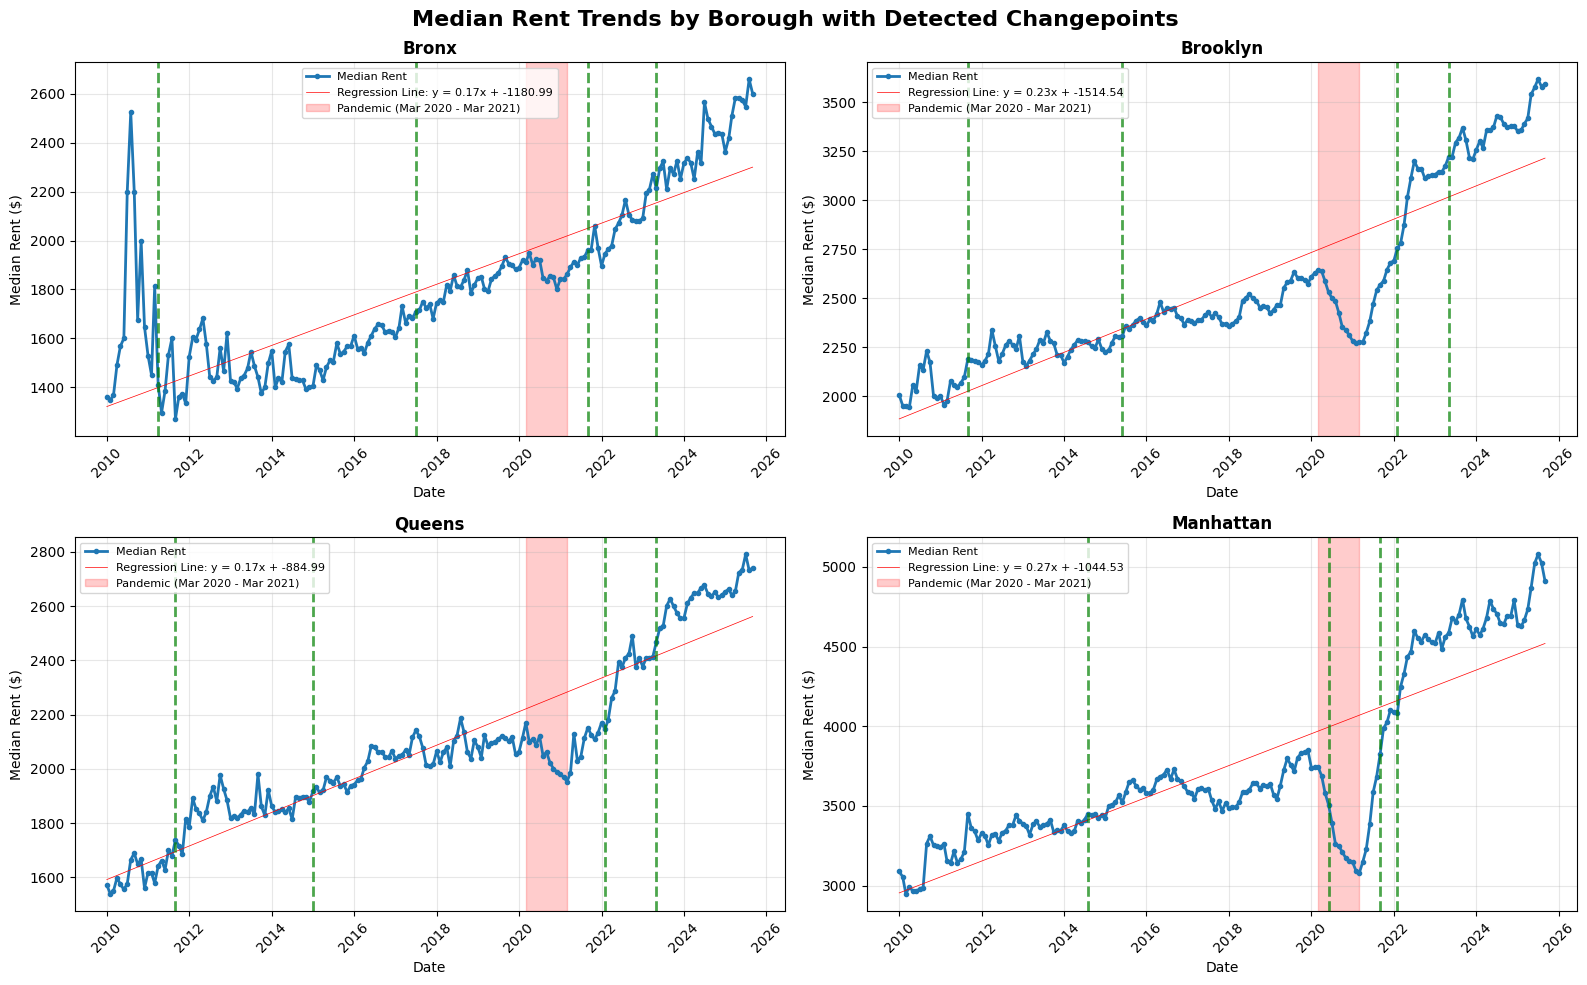

In [45]:
import matplotlib.dates as mdates

# detecting changepoints for monthly median rent at the borough-level
changepoints_rent = {}
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Median Rent Trends by Borough with Detected Changepoints', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, borough in enumerate(rent_df['borough'].unique()):
    borough_data = rent_df[rent_df['borough'] == borough].copy()
    borough_data = borough_data.sort_values('date')
    borough_data['avg_rent_all'] = borough_data['avg_rent_all'].astype(np.float32)
    
    ax = axes[idx]
    
    # Plot rent data
    ax.plot(borough_data['date'], borough_data['avg_rent_all'], marker='o', ms=3, linewidth=2, label='Median Rent')
    # Convert dates to numerical format
    dates_numeric = mdates.date2num(borough_data['date'])
    # calculate the polynomial values
    m, b = np.polyfit(dates_numeric, borough_data['avg_rent_all'], 1)
    # plot the linear regression line
    ax.plot(borough_data['date'], (m*dates_numeric + b), color='red', linewidth=0.5, label=f'Regression Line: y = {m:.2f}x + {b:.2f}')

    
    # Detect changepoints
    if len(borough_data) > 5:
        changepoints = detect_changepoints(borough_data['avg_rent_all'], n_bkps=4)
        changepoints_rent[borough] = [borough_data.iloc[cp]['date'] if cp < len(borough_data) else borough_data['date'].max() for cp in changepoints]
        
        # Mark pandemic period
        ax.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2021-03-01'), alpha=0.2, color='red', label='Pandemic (Mar 2020 - Mar 2021)')
        
        # Mark detected changepoints
        for cp in changepoints:
            if cp < len(borough_data):
                ax.axvline(borough_data.iloc[cp]['date'], color='green', linestyle='--', linewidth=2, alpha=0.7)
    
    ax.set_title(f'{borough}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Median Rent ($)')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

ValueError: min() iterable argument is empty

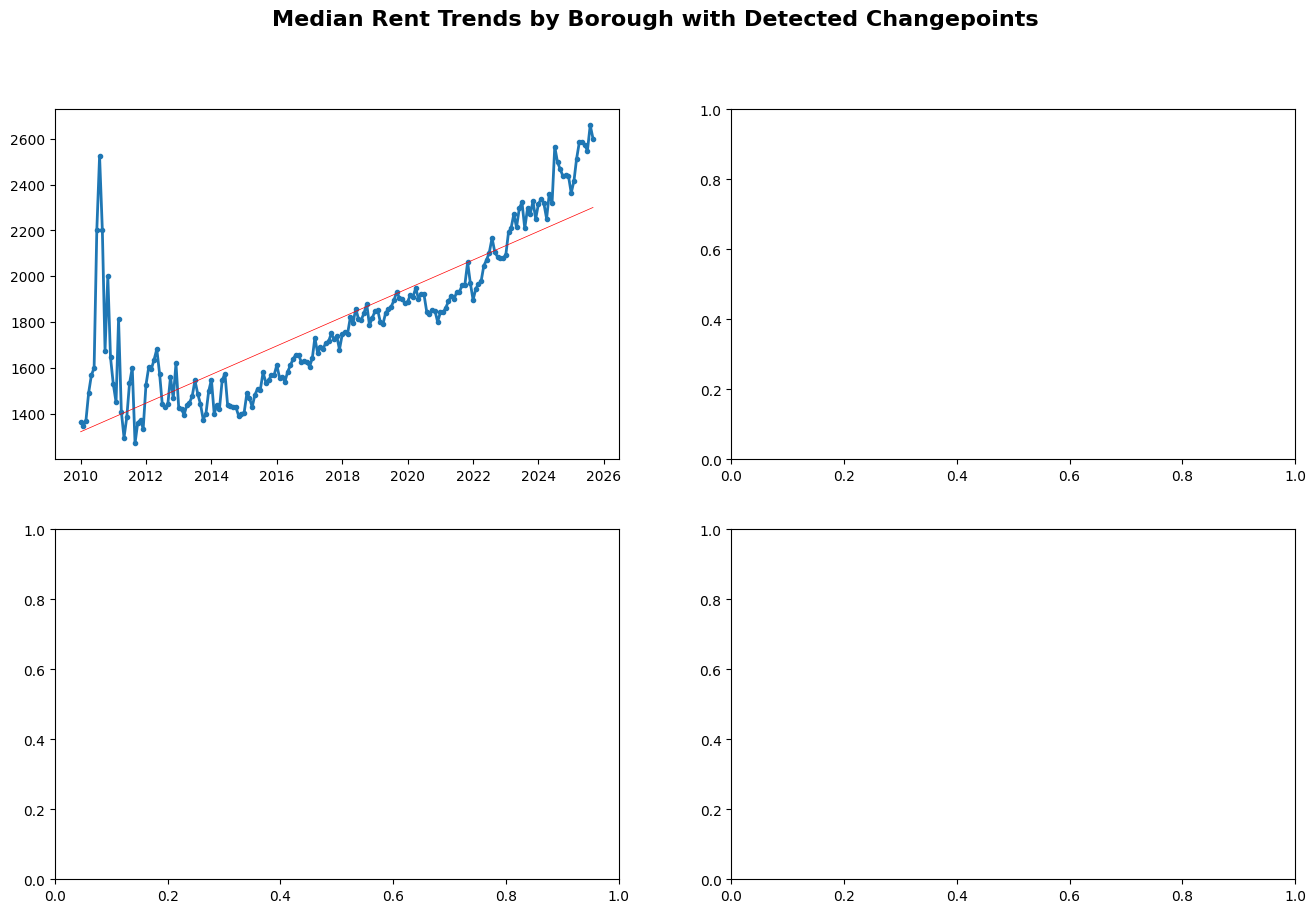

In [54]:
def detect_adaptive_changepoints(series, penalty=10):
    """
    Use PELT to automatically determine number of changepoints
    Penalty controls sensitivity: higher = fewer changepoints
    """

    # Work with first differences to capture slope changes
    #differences = series.diff().dropna()
    
    algo = rpt.Pelt(model="l2", min_size=6).fit(series.values.reshape(-1, 1))
    changepoints = algo.predict(pen=penalty)
    
    # Shift indices
    changepoints = [cp + 1 for cp in changepoints if cp + 1 < len(series)]
    
    return changepoints

# adaptive changepoint detection for monthly median rent at the borough-level
changepoints_rent = {}
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Median Rent Trends by Borough with Detected Changepoints', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, borough in enumerate(rent_df['borough'].unique()):
    borough_data = rent_df[rent_df['borough'] == borough].copy()
    borough_data = borough_data.sort_values('date')
    borough_data['avg_rent_all'] = borough_data['avg_rent_all'].astype(np.float32)
    
    ax = axes[idx]
    
    # Plot rent data
    ax.plot(borough_data['date'], borough_data['avg_rent_all'], marker='o', ms=3, linewidth=2, label='Median Rent')
    # Convert dates to numerical format
    dates_numeric = mdates.date2num(borough_data['date'])
    # calculate the polynomial values
    m, b = np.polyfit(dates_numeric, borough_data['avg_rent_all'], 1)
    # plot the linear regression line
    ax.plot(borough_data['date'], (m*dates_numeric + b), color='red', linewidth=0.5, label=f'Regression Line: y = {m:.2f}x + {b:.2f}')

    
    # Detect changepoints
    if len(borough_data) > 5:
        # calc the derivative of the series to capture the slope
        slope = borough_data['avg_rent_all'].diff() / np.gradient(borough_data['avg_rent_all'].index)
        changepoints = detect_adaptive_changepoints(slope, penalty=50)
        # original calc method
        #changepoints = detect_adaptive_changepoints(borough_data['avg_rent_all'], penalty=50)
        changepoints_rent[borough] = [borough_data.iloc[cp]['date'] if cp < len(borough_data) else borough_data['date'].max() for cp in changepoints]
        
        # Mark pandemic period
        ax.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2021-03-01'), alpha=0.2, color='red', label='Pandemic (Mar 2020 - Mar 2021)')
        
        # Mark detected changepoints
        for cp in changepoints:
            if cp < len(borough_data):
                ax.axvline(borough_data.iloc[cp]['date'], color='green', linestyle='--', linewidth=2, alpha=0.7)
    
    ax.set_title(f'{borough}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Median Rent ($)')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [51]:
slope = borough_data['avg_rent_all'].diff() / np.gradient(borough_data['avg_rent_all'].index)
type(slope)

pandas.core.series.Series

In [48]:
borough_data['avg_rent_all'].index

Index([378, 379, 380, 381, 382, 383, 384, 385, 386, 387,
       ...
       557, 558, 559, 560, 561, 562, 563, 564, 565, 566],
      dtype='int64', length=189)

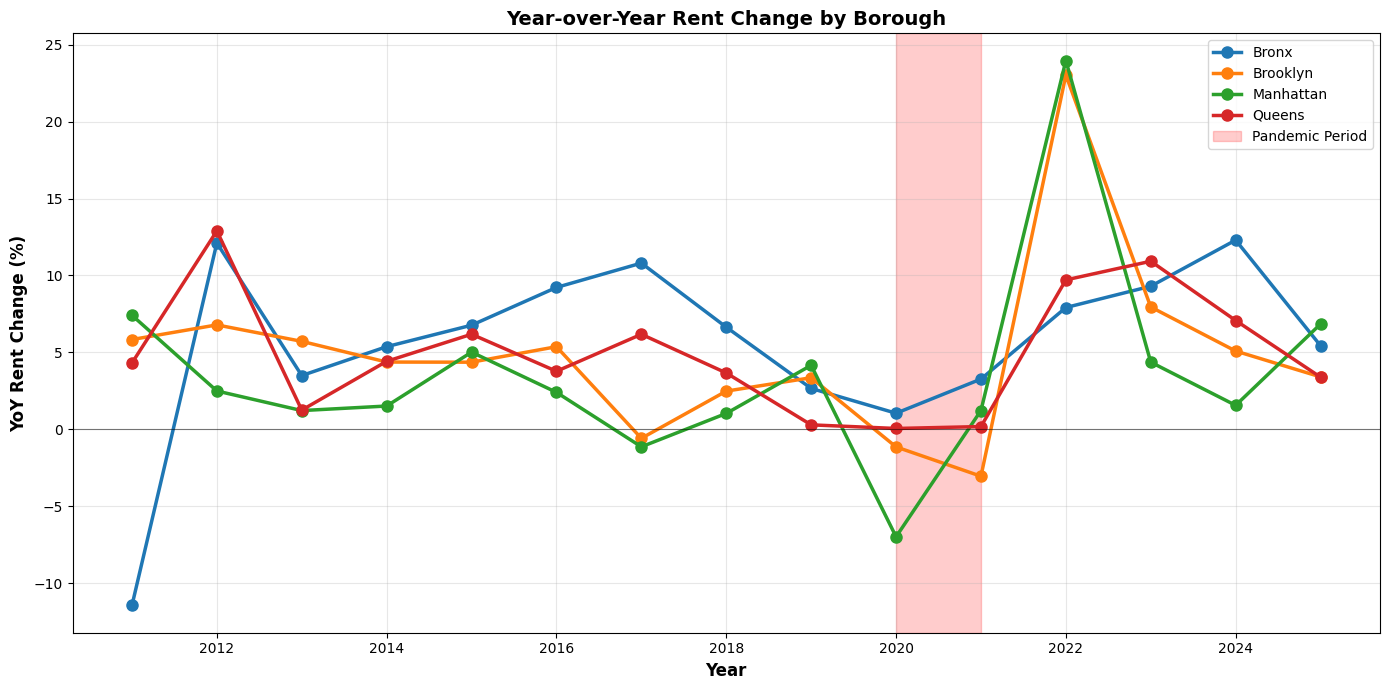

In [23]:
# visualizing year-over-year rent changes
fig, ax = plt.subplots(figsize=(14, 7))

for borough in yoy_rent_df['borough'].unique():
    borough_data = yoy_rent_df[yoy_rent_df['borough'] == borough].sort_values('year')
    ax.plot(borough_data['year'], borough_data['yoy_rent_change_pct_all'], 
            marker='o', linewidth=2.5, label=borough, markersize=8)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
ax.axvspan(2020, 2021, alpha=0.2, color='red', label='Pandemic Period')
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('YoY Rent Change (%)', fontsize=12, fontweight='bold')
ax.set_title('Year-over-Year Rent Change by Borough', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

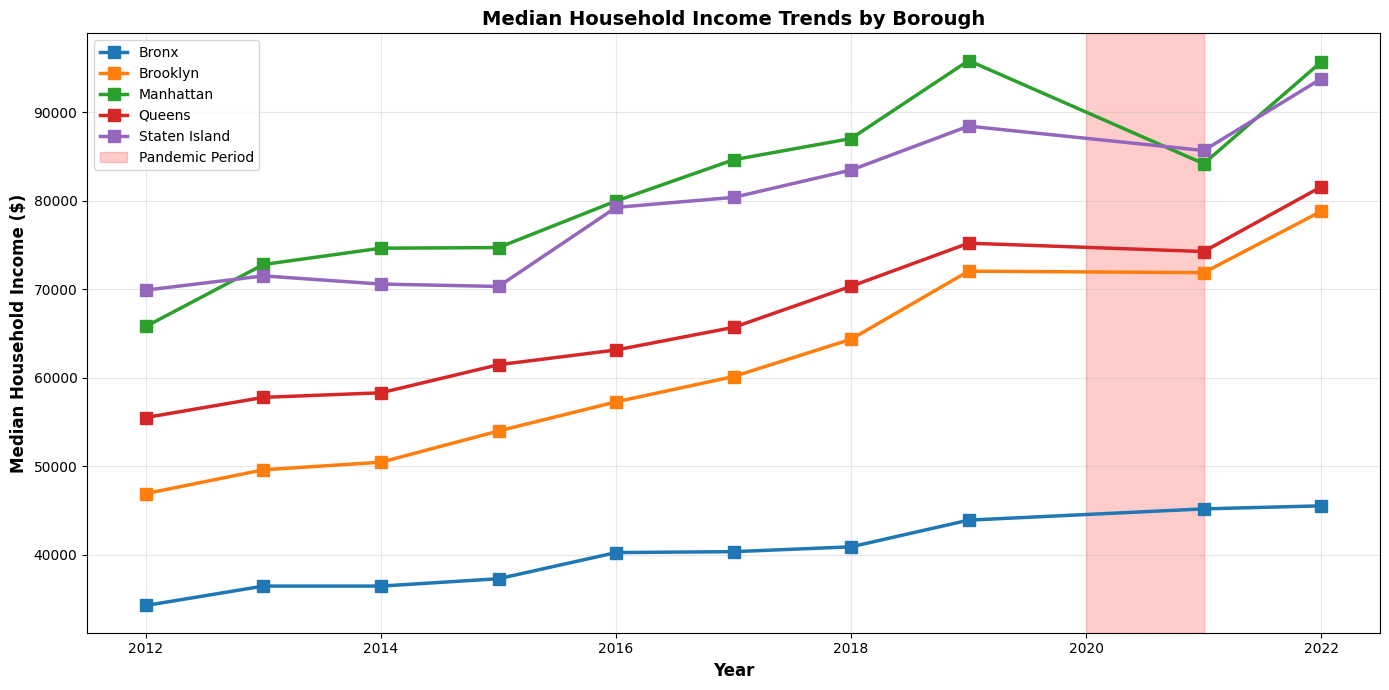

In [24]:
# analyzing annual median income
fig, ax = plt.subplots(figsize=(14, 7))

for borough in income_df['borough'].unique():
    borough_data = income_df[income_df['borough'] == borough].sort_values('year')
    ax.plot(borough_data['year'], borough_data['avg_income_all_hhs'], 
            marker='s', linewidth=2.5, label=borough, markersize=8)

ax.axvspan(2020, 2021, alpha=0.2, color='red', label='Pandemic Period')
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Median Household Income ($)', fontsize=12, fontweight='bold')
ax.set_title('Median Household Income Trends by Borough', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

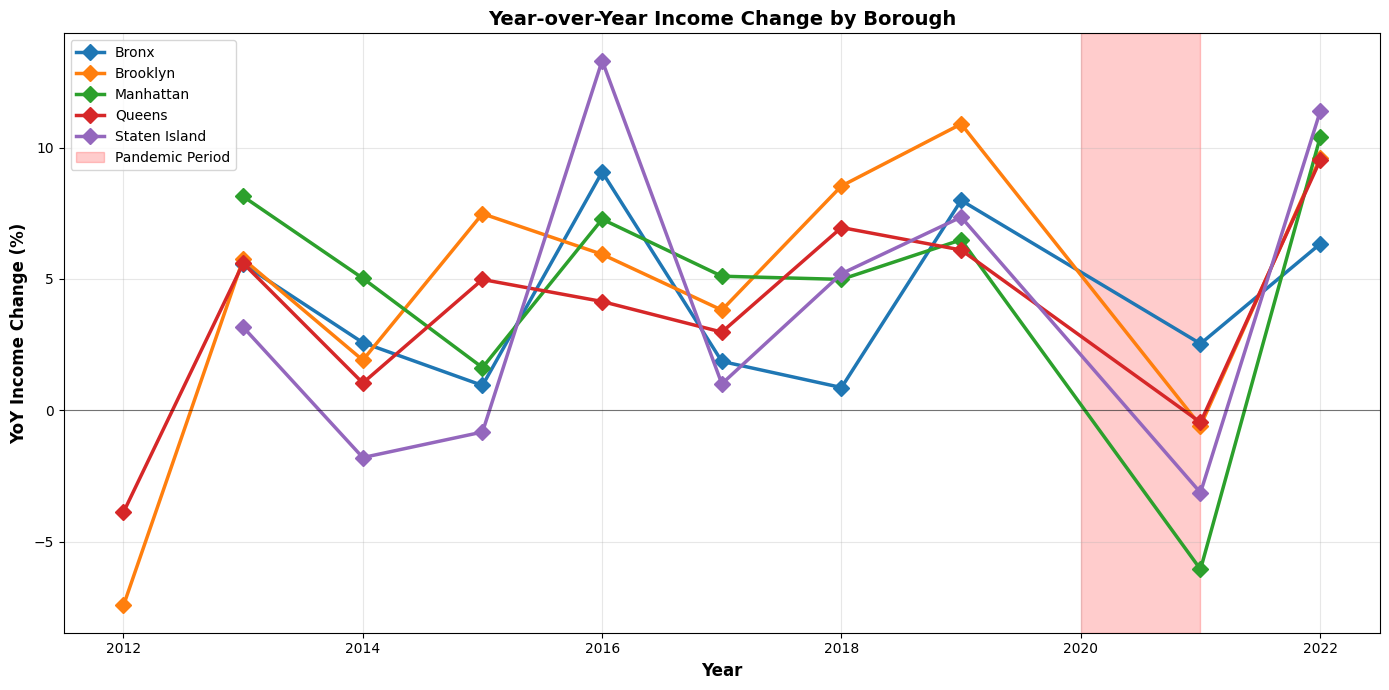

In [25]:
# visualizing year-over-year income trends
fig, ax = plt.subplots(figsize=(14, 7))

for borough in yoy_income_df['borough'].unique():
    borough_data = yoy_income_df[yoy_income_df['borough'] == borough].sort_values('year')
    ax.plot(borough_data['year'], borough_data['yoy_income_change_pct_all_hhs'], 
            marker='D', linewidth=2.5, label=borough, markersize=8)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
ax.axvspan(2020, 2021, alpha=0.2, color='red', label='Pandemic Period')
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('YoY Income Change (%)', fontsize=12, fontweight='bold')
ax.set_title('Year-over-Year Income Change by Borough', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary

In [26]:
print("\n" + "=" * 80)
print("SUMMARY: PANDEMIC IMPACT ANALYSIS")
print("=" * 80)

print("\n[DETECTED CHANGEPOINTS (Rent)]")
for borough, dates in changepoints_rent.items():
    print(f"  {borough}: {dates}")

print("\n[YoY RENT CHANGE DURING PANDEMIC]")
pandemic_rent = yoy_rent_df[(yoy_rent_df['year'] >= 2020) & (yoy_rent_df['year'] <= 2021)]
print(pandemic_rent.groupby('borough')[['yoy_rent_change_pct_all']].mean().round(2))

print("\n[YoY INCOME CHANGE DURING PANDEMIC]")
pandemic_income = yoy_income_df[(yoy_income_df['year'] >= 2020) & (yoy_income_df['year'] <= 2021)]
print(pandemic_income.groupby('borough')[['yoy_income_change_pct_all_hhs']].mean().round(2))

print("\n" + "=" * 80)
print("Analysis complete. Visualizations saved to current directory.")
print("=" * 80)


SUMMARY: PANDEMIC IMPACT ANALYSIS

[DETECTED CHANGEPOINTS (Rent)]
  Bronx: [Timestamp('2017-07-01 00:00:00'), Timestamp('2021-09-01 00:00:00'), Timestamp('2025-09-01 00:00:00')]
  Brooklyn: [Timestamp('2015-06-01 00:00:00'), Timestamp('2022-02-01 00:00:00'), Timestamp('2025-09-01 00:00:00')]
  Queens: [Timestamp('2015-01-01 00:00:00'), Timestamp('2022-02-01 00:00:00'), Timestamp('2025-09-01 00:00:00')]
  Manhattan: [Timestamp('2014-08-01 00:00:00'), Timestamp('2022-02-01 00:00:00'), Timestamp('2025-09-01 00:00:00')]

[YoY RENT CHANGE DURING PANDEMIC]
          yoy_rent_change_pct_all
borough                          
Bronx                    2.159272
Brooklyn                -2.092674
Manhattan               -2.877742
Queens                   0.120625

[YoY INCOME CHANGE DURING PANDEMIC]
              yoy_income_change_pct_all_hhs
borough                                    
Bronx                                2.5336
Brooklyn                          -0.593824
Manhattan                